In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


c:\Users\cjong\Projects\education\kpmg2\KPMG_MTA_Data_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Run Data Analysis

## Data Retrieval, metric result for MAE & MAPE, and feature importance plot

16:34:55 - cmdstanpy - INFO - Chain [1] start processing
16:34:56 - cmdstanpy - INFO - Chain [1] done processing


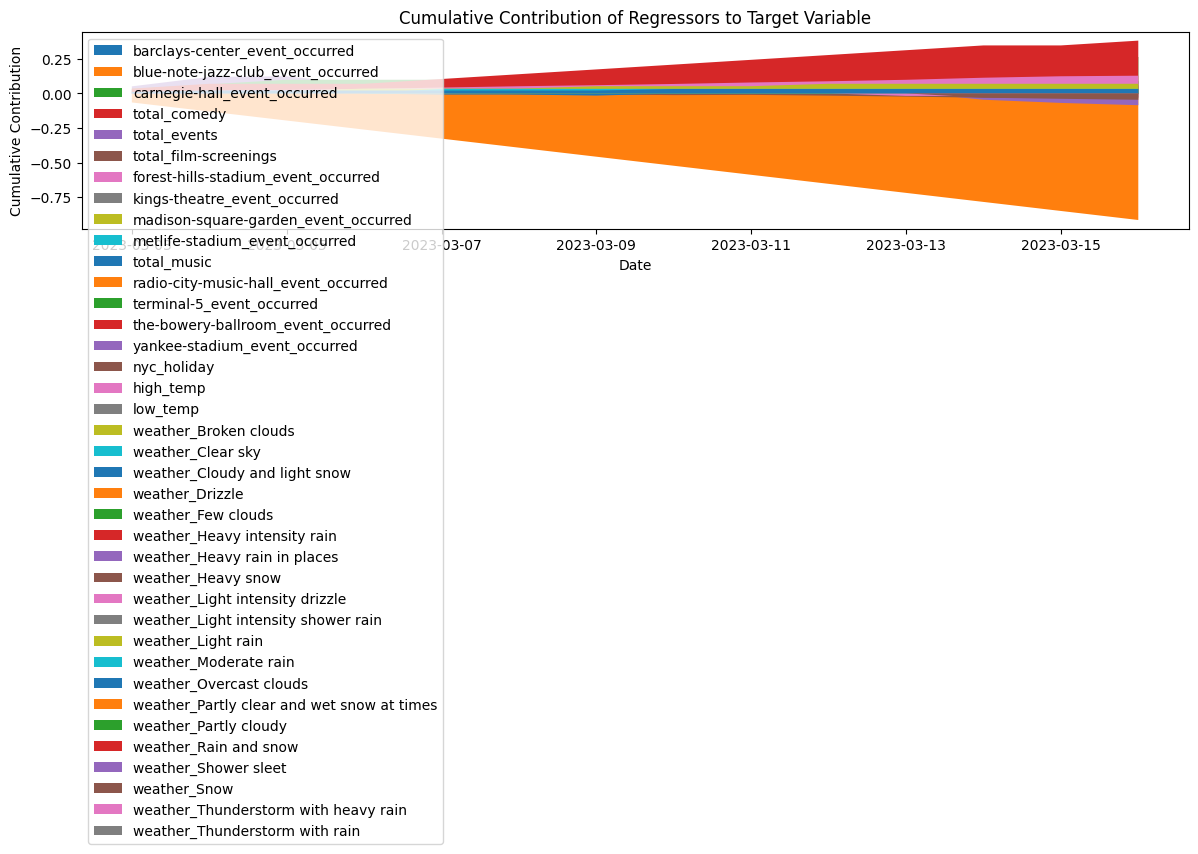

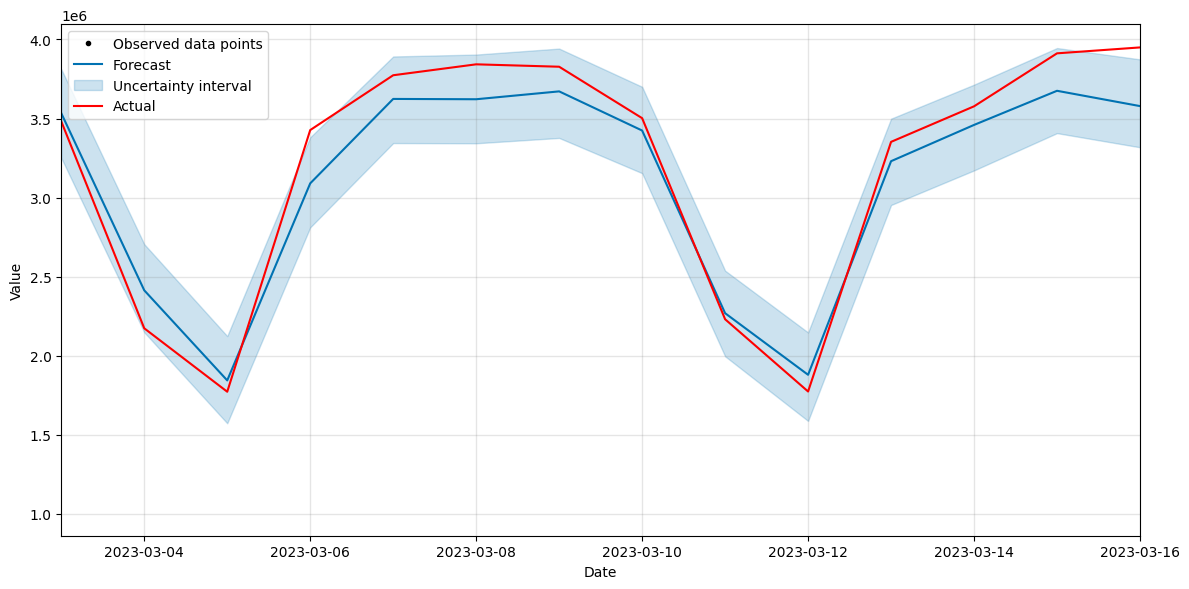

In [2]:

# Load the data
data = pd.read_csv('../data/consolidated_signals.csv')
data['date'] = pd.to_datetime(data['date'])
start_date = '2020-04-20'
end_date = '2023-03-16'
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Perform one-hot encoding for 'weather' column
data = pd.get_dummies(data, prefix=['weather'], columns=['weather'])

# Rename columns for Prophet requirement
data = data.rename(columns={"date": "ds", "ridership": "y"})

# Drop any rows with null values
data = data.dropna()

# Create training and testing sets
fold7 = data[(data['ds'] >= "2022-02-01") & (data['ds'] <= "2023-03-02")]
testing = data[(data['ds'] >= "2023-03-03") & (data['ds'] <= "2023-03-16")]

# Initialize the Prophet model
m = Prophet(changepoint_prior_scale=0.010, seasonality_prior_scale=10, holidays_prior_scale=10, seasonality_mode='multiplicative')

# Add the regressors to the model for both training and testing sets
for column in fold7.columns:
    if column != 'ds' and column != 'y':
        m.add_regressor(column)

# Fit the model to the training set
m.fit(fold7)

# Make predictions for the testing set
forecast = m.predict(testing)

# Create a stacked area plot for cumulative contributions of regressors
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate through each regressor and plot its cumulative contribution to the target variable
for column in fold7.columns:
    if column != 'ds' and column != 'y':
        ax.fill_between(testing['ds'], forecast[column].cumsum(), label=column)

ax.set_title('Cumulative Contribution of Regressors to Target Variable')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Contribution')
ax.legend(loc='upper left') # Update legend position
plt.tight_layout() # Add tight layout to prevent overlapping
plt.show()

# Plot the actual values and forecast
fig = m.plot(forecast, xlabel='Date', ylabel='Value', figsize=(12, 6)) # Increase plot size
fig.gca().set_xlim([testing['ds'].min(), testing['ds'].max()])
dates = testing['ds']
plt.plot(dates, testing['y'], label='Actual', color='red')
plt.legend()
plt.tight_layout() # Add tight layout to prevent overlapping
plt.show()

# Calculate Mean Absolute Percentage Error (MAPE)
y_true = testing['y'].values
y_pred = forecast['yhat'].values
absolute_percentage_error = np.abs((y_true - y_pred) / y_true)
mean_absolute_percentage_error = np.mean(absolute_percentage_error) * 100

## Forecast components plots

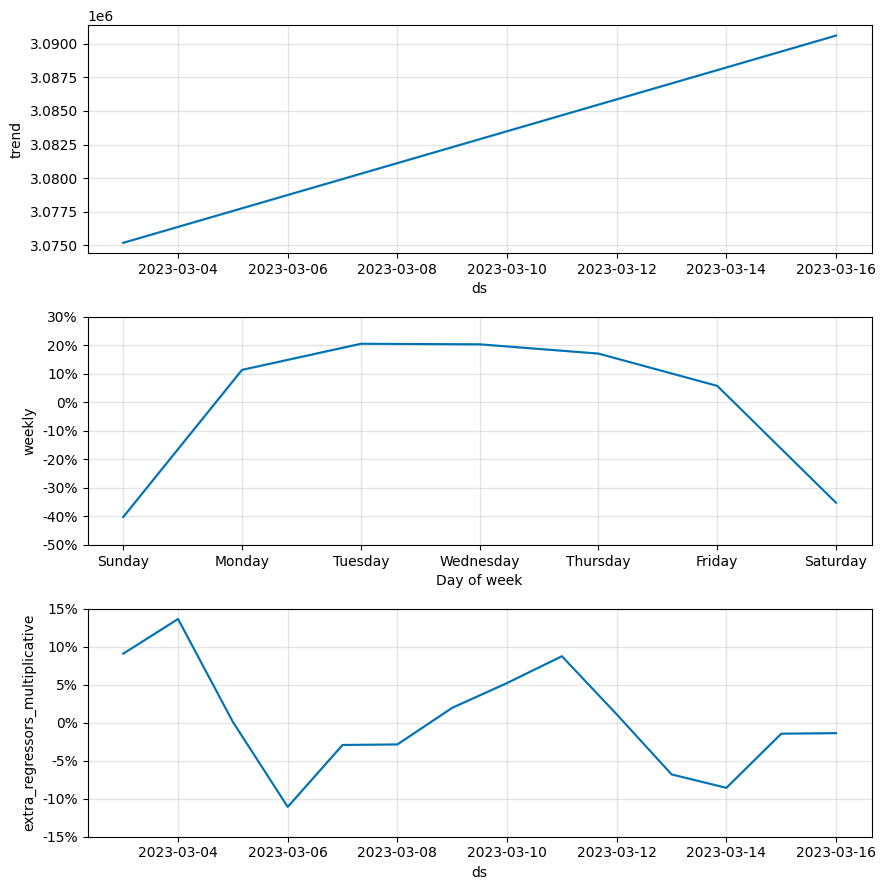

In [3]:
fig = m.plot_components(forecast)
plt.show()


## Contributions of variables for each date

In [4]:
# Create an empty dataframe to store the contributions
contributions = pd.DataFrame()

# Iterate through each regressor and calculate its contribution for each time period
for column in fold7.columns:
    if column != 'ds' and column != 'y':
        contributions[column] = forecast[column]

# Add the date column from the testing dataframe to the contributions dataframe
contributions['date'] = testing['ds'].values

# Set the date column as the index of the contributions dataframe
contributions.set_index('date', inplace=True)


In [5]:
# contributions.to_csv('./contributions.csv', index=True)

In [6]:
contributions

,barclays-center_event_occurred,blue-note-jazz-club_event_occurred,carnegie-hall_event_occurred,total_comedy,total_events,total_film-screenings,forest-hills-stadium_event_occurred,kings-theatre_event_occurred,madison-square-garden_event_occurred,metlife-stadium_event_occurred,...,weather_Light rain,weather_Moderate rain,weather_Overcast clouds,weather_Partly clear and wet snow at times,weather_Partly cloudy,weather_Rain and snow,weather_Shower sleet,weather_Snow,weather_Thunderstorm with heavy rain,weather_Thunderstorm with rain
date,,,,,,,,,,,,,,,,,,,,,
2023-03-03,0.000000,-0.065275,0.000000,-0.001836,0.050820,0.004147,0.0,0.014633,0.000000,0.0,...,0.0,0.0,0.010533,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2023-03-04,0.006175,-0.065275,0.000000,-0.002177,0.068120,0.011347,0.0,0.014633,0.005488,0.0,...,0.0,0.0,0.010533,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2023-03-05,0.006175,-0.065275,0.000000,0.000551,0.004381,-0.002254,0.0,0.000000,0.005488,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2023-03-06,0.000000,-0.065275,0.000000,0.001744,-0.059357,-0.003854,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2023-03-07,0.006175,-0.065275,0.000000,0.000721,-0.039325,-0.007854,0.0,0.000000,0.005488,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2023-03-08,0.006175,-0.065275,0.000000,0.001403,-0.011098,-0.007854,0.0,0.000000,0.005488,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2023-03-09,0.006175,-0.065275,0.000000,0.000721,-0.011098,-0.001453,0.0,0.000000,0.005488,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2023-03-10,0.000000,-0.065275,0.000000,0.000892,0.014397,-0.004654,0.0,0.000000,0.005488,0.0,...,0.0,0.0,0.010533,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2023-03-11,0.006175,-0.065275,0.000000,-0.003030,0.064478,0.001747,0.0,0.014633,0.005488,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## Contributions of regressor for each date

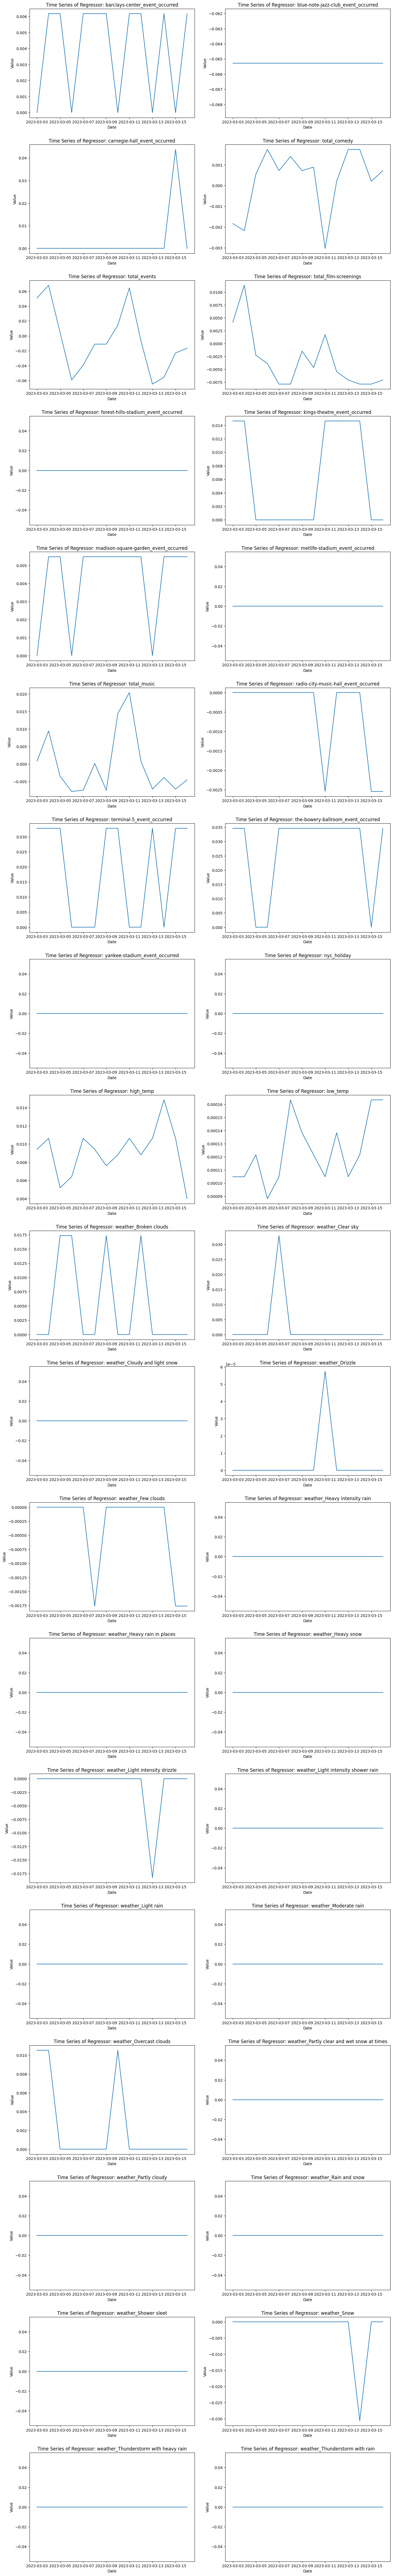

In [7]:
import matplotlib.pyplot as plt

# Assuming you have a fitted Prophet model named 'm' with extra regressors
# Access the regressor data from the testing set
regressor_data = forecast[['ds'] + list(m.extra_regressors.keys())]

# Determine the number of rows and columns for subplots
n_rows = (len(m.extra_regressors) + 1) // 2
n_cols = 2

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.tight_layout(pad=5)

# Loop through each regressor and plot its time series data in a subplot
for i, regressor_name in enumerate(m.extra_regressors.keys()):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axes[row_idx, col_idx]
    ax.plot(regressor_data['ds'], regressor_data[regressor_name])
    ax.set_title(f'Time Series of Regressor: {regressor_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

# Remove any unused subplots
if len(m.extra_regressors) % 2 != 0:
    axes[-1, -1].remove()

plt.show()

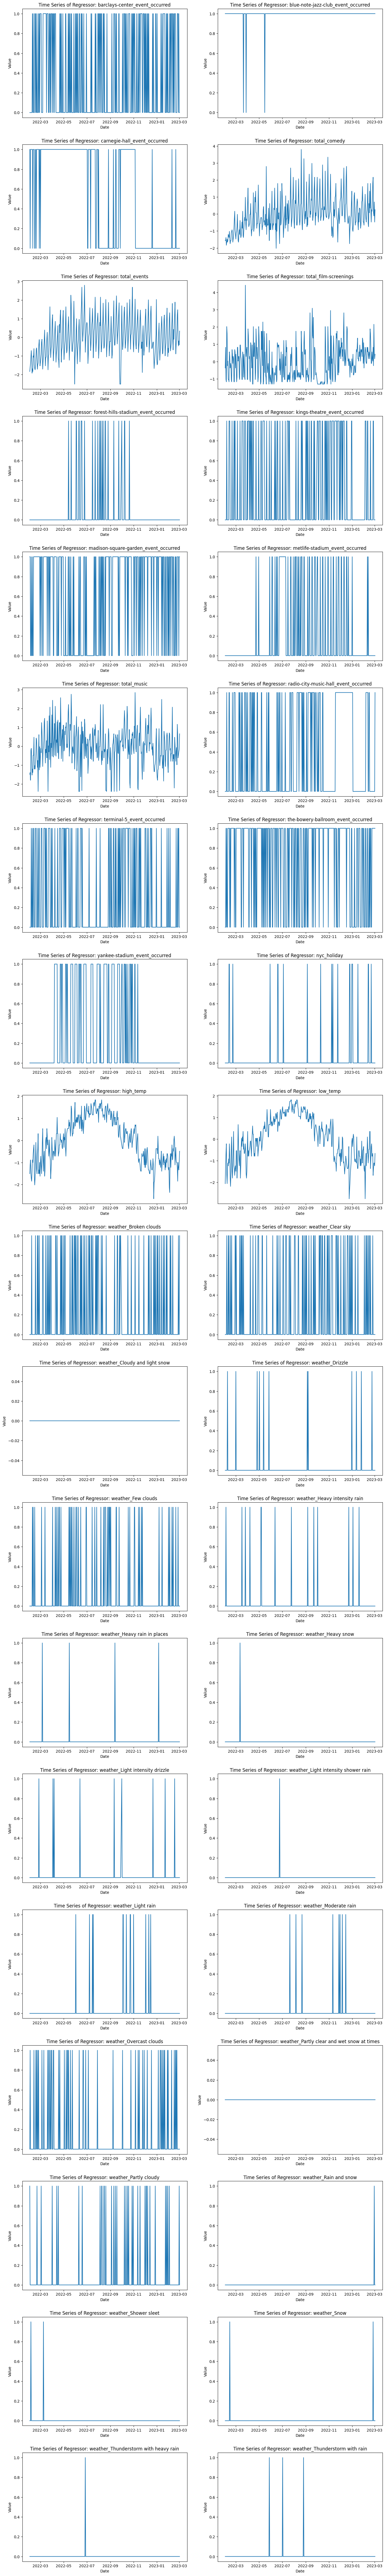

In [8]:
import matplotlib.pyplot as plt

# Assuming you have a fitted Prophet model named 'm' with extra regressors
# Access the regressor data
regressor_data = m.history

# Extract the names of the regressors
regressor_names = m.extra_regressors.keys()

# Determine the number of rows and columns for subplots
n_rows = (len(regressor_names) + 1) // 2
n_cols = 2

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.tight_layout(pad=5)

# Loop through each regressor and plot its time series data in a subplot
for i, regressor_name in enumerate(regressor_names):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = axes[row_idx, col_idx]
    ax.plot(regressor_data['ds'], regressor_data[regressor_name])
    ax.set_title(f'Time Series of Regressor: {regressor_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

# Remove any unused subplots
if len(regressor_names) % 2 != 0:
    axes[-1, -1].remove()

plt.show()


# Results

In [9]:
print(f"absolute_percentage_error: {absolute_percentage_error}")
print(f"mean_absolute_percentage_error: {mean_absolute_percentage_error}")

absolute_percentage_error: [0.01485437 0.1105276  0.04037582 0.09835523 0.03969776 0.05747068
 0.04072887 0.02234477 0.01715996 0.05955572 0.03643641 0.03288835
 0.06054885 0.09395493]
mean_absolute_percentage_error: 5.177852316988035


In [10]:
# Find the highest value in each column
max_values = contributions.max()

# Iterate over each column and find the key and value for the highest value
print("Highest Value & Date pairs of feature importance in the forecasted dates")
result = []
for column in contributions.columns:
    key = contributions[column].idxmax()
    value = contributions.loc[key, column]
    result.append(f"The highest of '{column}'  with a value of '{value}' on day '{key}'")

# Print the formatted text
for text in result:
    print(text)

Highest Value & Date pairs of feature importance in the forecasted dates
The highest of 'barclays-center_event_occurred'  with a value of '0.00617488' on day '2023-03-04 00:00:00'
The highest of 'blue-note-jazz-club_event_occurred'  with a value of '-0.0652748' on day '2023-03-03 00:00:00'
The highest of 'carnegie-hall_event_occurred'  with a value of '0.0437729' on day '2023-03-15 00:00:00'
The highest of 'total_comedy'  with a value of '0.0017439873905232901' on day '2023-03-06 00:00:00'
The highest of 'total_events'  with a value of '0.0681200064426665' on day '2023-03-04 00:00:00'
The highest of 'total_film-screenings'  with a value of '0.01134689944466389' on day '2023-03-04 00:00:00'
The highest of 'forest-hills-stadium_event_occurred'  with a value of '0.0' on day '2023-03-03 00:00:00'
The highest of 'kings-theatre_event_occurred'  with a value of '0.0146328' on day '2023-03-03 00:00:00'
The highest of 'madison-square-garden_event_occurred'  with a value of '0.00548783' on day '

In [11]:
# Compute the sum of each column
column_sums = contributions.sum()

# Sort the column sums in descending order
sorted_sums = column_sums.sort_values(ascending=False)

# Print the results in descending order
print("Decending value of aggregated sum of feature importance in the forecasted dates")
for column, value in sorted_sums.items():
    print(f"Sum of '{column}' has a lifetime significance of {value}.")

Decending value of aggregated sum of feature importance in the forecasted dates
Sum of 'the-bowery-ballroom_event_occurred' has a lifetime significance of 0.38091460000000005.
Sum of 'terminal-5_event_occurred' has a lifetime significance of 0.2627920000000001.
Sum of 'high_temp' has a lifetime significance of 0.12771380034523638.
Sum of 'kings-theatre_event_occurred' has a lifetime significance of 0.0877968.
Sum of 'weather_Broken clouds' has a lifetime significance of 0.0694024.
Sum of 'madison-square-garden_event_occurred' has a lifetime significance of 0.06036613.
Sum of 'barclays-center_event_occurred' has a lifetime significance of 0.05557392.
Sum of 'carnegie-hall_event_occurred' has a lifetime significance of 0.0437729.
Sum of 'weather_Clear sky' has a lifetime significance of 0.0329161.
Sum of 'weather_Overcast clouds' has a lifetime significance of 0.0316005.
Sum of 'total_comedy' has a lifetime significance of 0.003615520127517689.
Sum of 'low_temp' has a lifetime significan